#### Team El Tony:
    Lara Fried, 15-729-627
    Mark Woolley, 19-745-223
    Matija Zver, 21-705-405
    Zejie Guo, 21-749-767


#### Rminder of the task:


#### Github link: 
https://github.com/mwooll/ElTony

#### Tool’s task list:

- Additional datasets:
    - Type Interactions: https://github.com/mwooll/ElTony/blob/main/backend/src/typing_chart.csv
    - Pokémon Image dataset from kaggle: https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types?select=pokemon.csv


- Recommender System:
    - For the recommendation system we used scikit-surprise. We plan on calculating the ideal stats for a recommedation and rank the Pokémon by similarity. https://surprise.readthedocs.io/en/stable/similarities.html
    - Another tutorial using scikit-surprise builds a collaborative filtering recommender system, we might use this as well. https://www.alldatascience.com/recommender-systems/simple-recipe-recommender-system-with-scikit-surprise/

In [ ]:
pip install chart-studio

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly import tools
from chart_studio import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
from PIL import Image
init_notebook_mode(connected=True)

plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

# Data Preprocessing

In [108]:
# Load the dataset
unprocessed = pd.read_csv('data/pokemon.csv')

type_interaction = pd.read_csv('mechanics/type_chart.csv', index_col=0)

image_folder = 'poke_images/'

In [37]:
unprocessed.columns

Index(['Number', 'Name', 'Type_1', 'Type_2', 'Total', 'HP', 'Attack',
       'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation', 'isLegendary',
       'Color', 'hasGender', 'Pr_Male', 'Egg_Group_1', 'Egg_Group_2',
       'hasMegaEvolution', 'Height_m', 'Weight_kg', 'Catch_Rate',
       'Body_Style'],
      dtype='object')

In [13]:
unprocessed[unprocessed.columns[:14]].head()

,Number,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,Green
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,Green
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,Green
3,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,Red
4,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False,Red


In [14]:
unprocessed[unprocessed.columns[14:]].head()

,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
1,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
2,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
3,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
4,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed


## Classification of Attributes

In [15]:
# 0. PokéDex number
print("The dataset contains the PokéDex number (named just 'Number') of every Pokémon, which is an ordinal variable.")
print("We will use it as index.")
indexed = unprocessed.set_index(keys="Number", drop=True)

The dataset contains the PokéDex number (named just 'Number') of every Pokémon, which is an ordinal variable.
We will use it as index.


In [16]:
# 1. core_col are the attributes which determine if a Pokémon is a good choice for a team
core_col = ["Type_1", "Type_2", 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed']

print("Type_1 and Type_2 are categorical with 18 values for Type_1 (there are 18 different types).")
print("Type_2 has 19 categories since it can also be None/NaN, which makes semantically sense, \
so we won't be dropping this column.")
print("HP, Attack, Defense, Sp_Atk, Sp_Def and Speed are positive integers, i.e., discrete quantitative attributes.")

Type_1 and Type_2 are categorical with 18 values for Type_1 (there are 18 different types).
Type_2 has 19 categories since it can also be None/NaN, which makes semantically sense, so we won't be dropping this column.
HP, Attack, Defense, Sp_Atk, Sp_Def and Speed are positive integers, i.e., discrete quantitative attributes.


In [17]:
# 2. filt_col are the attributes most useful for filtering and searching apart from core_col
filt_col = ["Name", "Generation", "isLegendary", "Color", "Body_Style"]
print("Name is a nominal variable and is next to the PokéDex number the only attribute with a unique value per datapoint.")
print("Generation is an ordinal attribute with values from 1 to 6.")
print("isLegendary is a boolean attribute.")
print(f"Color and Body_Style are both categorical, with {len(unprocessed.Color.unique())} \
and {len(unprocessed.Body_Style.unique())} categories respectively.")

Name is a nominal variable and is next to the PokéDex number the only attribute with a unique value per datapoint.
Generation is an ordinal attribute with values from 1 to 6.
isLegendary is a boolean attribute.
Color and Body_Style are both categorical, with 10 and 14 categories respectively.


In [18]:
# 3. other_col are the attributes we will most likely not need at all
other_col = ["hasGender", "Pr_Male", "Egg_Group_1", "Egg_Group_2", "Catch_Rate", "hasMegaEvolution", "Height_m", "Weight_kg"]
print(f"Most likely, we will not use the columns: {other_col}, but if we end up using one or two, than only as filter options.")
print("hasGender and hasMegaEvolution are boolean attributes.")
print(f"Egg_Group_1 and Egg_Group_2 are nominal attrbiutes, with {len(unprocessed.Egg_Group_1.unique())} \
and {len(unprocessed.Egg_Group_2.unique())} categories respectively.")
print("Pr_Male, Catch_Rate, Height_m and Weight_kg are quantitative attributes.")

Most likely, we will not use the columns: ['hasGender', 'Pr_Male', 'Egg_Group_1', 'Egg_Group_2', 'Catch_Rate', 'hasMegaEvolution', 'Height_m', 'Weight_kg'], but if we end up using one or two, than only as filter options.
hasGender and hasMegaEvolution are boolean attributes.
Egg_Group_1 and Egg_Group_2 are nominal attrbiutes, with 15 and 14 categories respectively.
Pr_Male, Catch_Rate, Height_m and Weight_kg are quantitative attributes.


## Cleaned Dataset

In [19]:
# deleting columns that we do not need
pokedata = indexed.drop(columns=other_col)
pokedata.head()

,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,Body_Style
Number,,,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,Green,quadruped
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,Green,quadruped
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,Green,quadruped
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,Red,bipedal_tailed
5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False,Red,bipedal_tailed


### Checking for null values in the attributes we focus on

In [20]:
# Type_2 is the only column where NaN is allowed
pokedata.isna().any()

Name           False
Type_1         False
Type_2          True
Total          False
HP             False
Attack         False
Defense        False
Sp_Atk         False
Sp_Def         False
Speed          False
Generation     False
isLegendary    False
Color          False
Body_Style     False
dtype: bool

## Visualization to get familiar with the Dataset

### Distribution of HP
The distribution pattern and concentration of HP stats among Pokémon

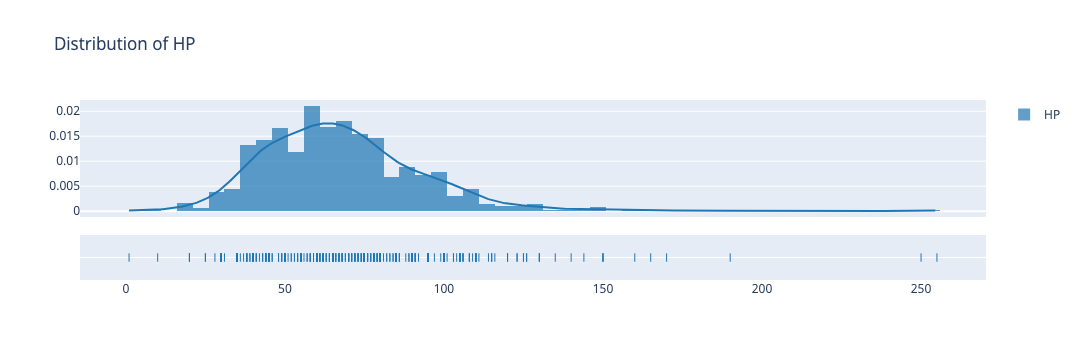

In [21]:
fig = ff.create_distplot([pokedata.HP], ['HP'], bin_size=5)
fig.update_layout(title="Distribution of HP") 
iplot(fig, filename='Basic Distplot')

### Distributions of Attack and Defense
Using histogram to compare the distributions of Attack and Defense stats side by side. It allows for a quick understanding of the frequency and spread of these stats within the Pokémon dataset.

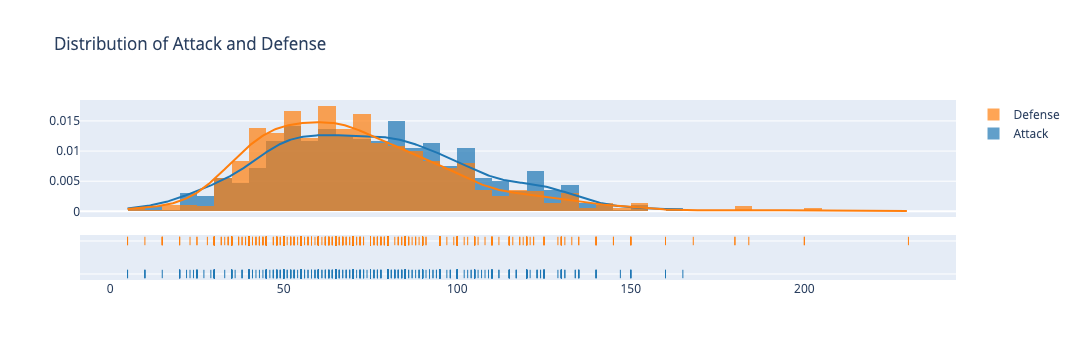

In [22]:
hist_data = [pokedata['Attack'], pokedata['Defense']]
group_labels = ['Attack', 'Defense']
fig = ff.create_distplot(hist_data, group_labels, bin_size=5)
fig.update_layout(title="Distribution of Attack and Defense") 
iplot(fig, filename='Distplot of attack and defense')

### Distribution of all Stats
Using box plots to compare multiple statistics, we can spot differences in the distribution of these statistics and understand their ranges, medians, quartiles, and potential outliers.

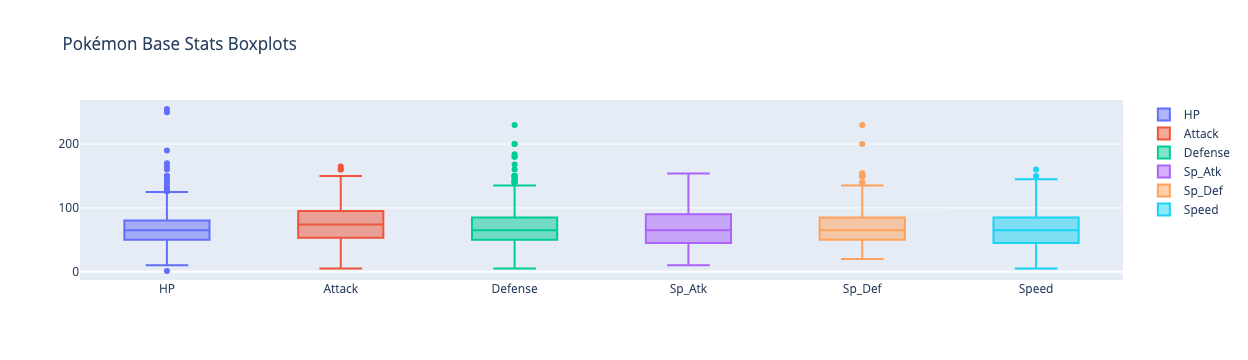

In [23]:
trace0 = go.Box(y=pokedata["HP"], name="HP")
trace1 = go.Box(y=pokedata["Attack"], name="Attack")
trace2 = go.Box(y=pokedata["Defense"], name="Defense")
trace3 = go.Box(y=pokedata["Sp_Atk"], name="Sp_Atk")
trace4 = go.Box(y=pokedata["Sp_Def"], name="Sp_Def")
trace5 = go.Box(y=pokedata["Speed"], name="Speed")
data = [trace0, trace1, trace2,trace3, trace4, trace5]
layout = {"title": "Pokémon Base Stats Boxplots"}
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Type interaction heatmap
Pokémon battles heavily rely on type advantages and weaknesses. This visualization provides a clear representation of which types are strong or weak against others.

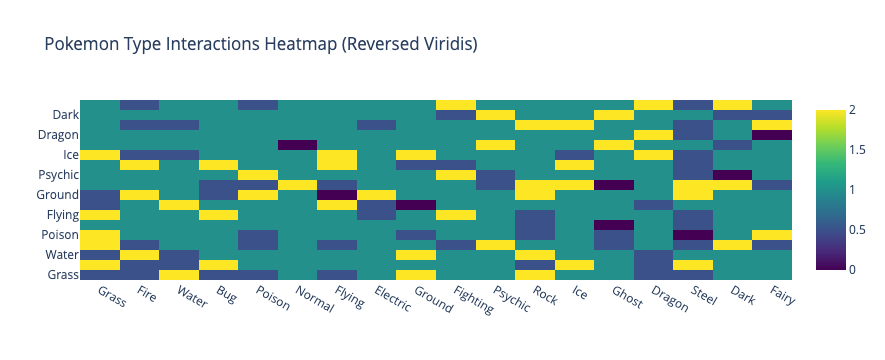

In [113]:
z = type_interaction.values.tolist()
x = type_interaction.columns.tolist()
y = type_interaction.index.tolist()

fig = go.Figure(data=go.Heatmap(z=z, x=x, y=y, colorscale='Viridis'))
fig.update_layout(title='Pokemon Type Interactions Heatmap (Reversed Viridis)')
fig.show()

### Scatterplot for Type combinations
Visualization of the distribution and frequency of different dual-type combinations among Pokémon species.
It helps in understanding the rarity or prevalence of specific dual-type combinations.

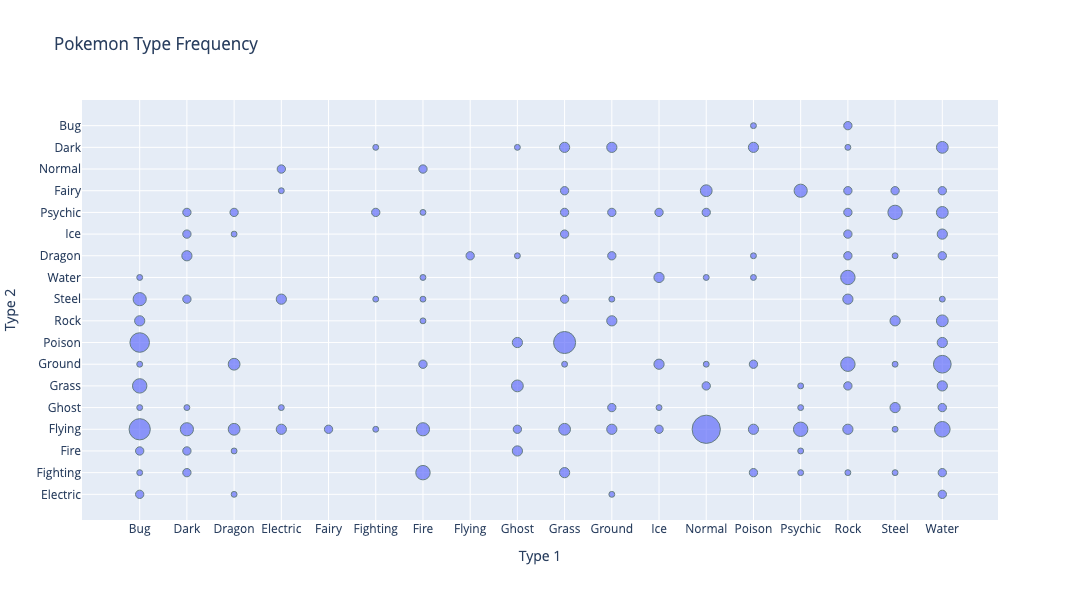

In [25]:
pokemon_count = pokedata.groupby(['Type_1', 'Type_2']).size().reset_index(name='Pokemon_Count')

fig = px.scatter(pokemon_count, x='Type_1', y='Type_2', size='Pokemon_Count', 
                 title='Pokemon Type Frequency',
                 labels={'Type_1': 'Type 1', 'Type_2': 'Type 2', 'Pokemon_Count': 'Number of Pokemon'},
                 width=800, height=600)

fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')), selector=dict(mode='markers'))

fig.show()

### Scatter plot of Defensive-Offensive with Type as colorscale:
This scatter plot visualizes the relationship between offensive and defensive stats of different Pokémon types. It provides an oveview of how different types perform in battles. This is important for players looking to strategize in Pokémon battles, as it highlights which types excel more in offensive capabilities versus defensive strengths. The plot allows users to identify trends, strengths, and weaknesses among Pokémon types, aiding in team building and battle tactics.

The scatters changes after the user filters for generations, opponent type, legendary, color, etc. in the configuration panel.

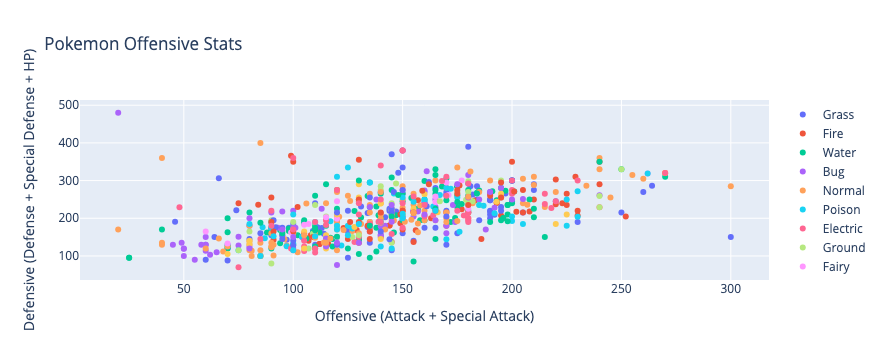

In [47]:
fig_offensive = go.Figure()
for poke_type in pokedata['Type_1'].unique():
    type_data = pokedata[pokedata['Type_1'] == poke_type]
    fig_offensive.add_trace(go.Scatter(
        x=type_data['Attack'] + type_data['Sp_Atk'],
        y=type_data['Defense'] + type_data['Sp_Def'] + type_data['HP'],
        mode='markers',
        name=poke_type,
        text=type_data['Name']
    ))

fig_offensive.update_layout(
    title='Pokemon Offensive Stats',
    xaxis_title='Offensive (Attack + Special Attack)',
    yaxis_title='Defensive (Defense + Special Defense + HP)'
)
iplot(fig_offensive)

# Scatter Plot for the visualization tool

### Comparison of two Pokémon's stats


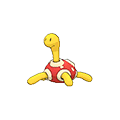
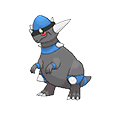

In [11]:
# Lowercase the names of Pokemon for matching image names
pokedata["Name"] = pokedata["Name"].str.lower()

pokemon_name_a = pokedata['Name'].loc[[pokedata['Attack'].idxmax()]].values[0]
pokemon_name_b = pokedata['Name'].loc[[pokedata['Defense'].idxmax()]].values[0]

pokemon_image_path_a = image_folder+pokemon_name_a+'.png'
pokemon_image_path_b = image_folder+pokemon_name_b+'.png'

a = pokedata.loc[[pokedata['Attack'].idxmax()]]
b = pokedata.loc[[pokedata['Defense'].idxmax()]]


data = [
    go.Scatterpolar(
        name = a.Name.values[0],
        r = [a['HP'].values[0],a['Attack'].values[0],a['Defense'].values[0],a['Sp_Atk'].values[0],a['Sp_Def'].values[0],a['Speed'].values[0],a["HP"].values[0]],
        theta = ['HP','Attack','Defense','Sp_Atk','Sp_Def','Speed','HP'],
        fill = 'toself',
        line =  dict(
                color = 'cyan'
            )
        ),
    go.Scatterpolar(
            name = b.Name.values[0],
            r = [b['HP'].values[0],b['Attack'].values[0],b['Defense'].values[0],b['Sp_Atk'].values[0],b['Sp_Def'].values[0],b['Speed'].values[0],b["HP"].values[0]],
            theta = ['HP','Attack','Defense','Sp_Atk','Sp_Def','Speed','HP'],
            fill = 'toself',
            line =  dict(
                color = 'orange'
            )
        )]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 200]
    )
  ),
  showlegend = True,
  title = "{} vs {} Stats Comparison".format(a.Name.values[0], b.Name.values[0])
)

# Load the image
img_a = Image.open(pokemon_image_path_a)
img_b = Image.open(pokemon_image_path_b)

# Add image to the layout
layout.images = [dict(
    source=img_b,
    x=0.85,
    y=0.5,
    xref="paper",
    yref="paper",
    sizex=0.7,
    sizey=0.7,
    xanchor="center",
    yanchor="middle"),
    dict(
        source=img_a,
        x= 0.15,
        y=0.5,
        xref="paper",
        yref="paper",
        sizex=0.7,
        sizey=0.7,
        xanchor="center",
        yanchor="middle"
    )]

fig = go.Figure(data=data, layout=layout)
fig.show()


### Visualization of the Recommended Team

In [148]:
rec_pokemon=['Seaking', 'Klang', 'Tangela', 'Gligar', 'Medicham', 'Seadra']

def visualize_pokemon_on_spider_map(rec_poke, pokedata, image_folder):
    pokedata["Name"] = pokedata["Name"].str.lower()

    data = []
    layout_images = []

    for index, pokemon_name in enumerate(rec_poke):
        pokemon_name_lower = pokemon_name.lower()

        pokemon_image_path = image_folder + pokemon_name_lower + '.png'

        pokemon_data = pokedata[pokedata['Name'] == pokemon_name_lower]
        if pokemon_data.empty:
            print(f"Pokemon {pokemon_name} not found in the dataset.")
            continue

        data.append(go.Scatterpolar(
            name=pokemon_name,
            r=pokemon_data[['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'HP']].values[0],
            theta=['HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'HP'],
            fill='toself'
        ))

        img = Image.open(pokemon_image_path)
        
        x_coord = 1  
        y_coord = 1.3 - index * 0.3

        layout_images.append(dict(
            source=img,
            x=x_coord,
            y=y_coord,
            xref="paper",
            yref="paper",
            sizex=0.3,
            sizey=0.3,
            xanchor="center",
            yanchor="middle"
        ))

    layout = go.Layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 200]
            )
        ),
        showlegend=True,
        title="Pokémon Stats Comparison"
    )

    layout.images = layout_images

    fig = go.Figure(data=data, layout=layout)
    fig.show()

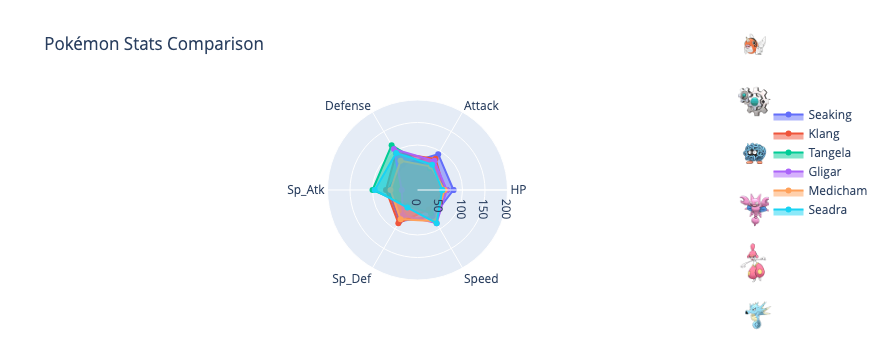

In [149]:
visualize_pokemon_on_spider_map(rec_pokemon, pokedata, image_folder)

In [ ]:
# Explain the Recommendation:

#### Group members contribution:
